# 🧪 Mechanisms of Action (MoA) Prediction Tutorial - Code Walkthrough 🧬

## **📌 Introduction**
Welcome to the MoA Prediction tutorial! In this guide, we will explore how to use machine learning techniques to predict drug mechanisms based on gene expression data. The dataset used is from the **Kaggle MoA competition**, which focuses on multi-label classification of drug effects.

**Background: Understanding the Mechanism of Action (MoA) in Drug Discovery**  

The **Mechanism of Action (MoA)** of a drug describes how a molecule interacts with biological targets to produce its pharmacological effects. According to the **National Cancer Institute (NCI)**, MoA refers to "how a drug or other substance produces an effect in the body". For example, a drug’s mechanism of action could be how it affects a specific target in a cell, such as an enzyme, or a cell function, such as cell growth. Knowing the mechanism of action of a drug may help provide information about the safety of the drug and how it affects the body. It may also help identify the right dose of a drug and which patients are most likely to respond to treatment (NCI, *NIH*).  

Historically, drug discovery was largely empirical. Many widely used drugs were discovered through **serendipity and traditional medicine**, long before their exact biological effects were understood. For instance, **paracetamol (acetaminophen)** was in clinical use for decades before researchers determined its MoA, which involves inhibition of cyclooxygenase (COX) enzymes and modulation of the endocannabinoid system. Similarly, early **antibiotics like penicillin** were discovered through natural processes, with their detailed molecular interactions uncovered much later.  

With advances in **molecular biology, high-throughput screening, and computational drug design**, modern pharmacology has transitioned toward a **target-based drug discovery model**. In this framework, researchers first **identify a disease-associated molecular target**, such as a receptor or enzyme, and then **design drugs** that selectively modulate its activity. This **rational drug design** approach increases efficacy, reduces side effects, and enables **personalized medicine** by tailoring treatments to individual patients' biological profiles.

---

**Why is Understanding MoA Important?**  

Understanding the MoA of a drug is **crucial** for several reasons, particularly in improving **efficacy, safety, and precision medicine**.  

1. **Optimizing Drug Delivery & Pharmacokinetics**  
   - As highlighted in *Holland-Frei Cancer Medicine*, a drug’s effect depends not only on its biochemical interaction with a target but also on **how well it reaches the target**. Factors such as **blood flow, diffusion characteristics, plasma protein binding, and metabolism** determine whether a drug can effectively engage its intended site of action (Ratain & Plunkett, 2003).  
   - For example, **chemotherapy drugs** targeting tumors face challenges such as **limited vascularization in large tumors**, which can reduce drug penetration and lead to treatment resistance.

2. **Enhancing Safety & Reducing Toxicity**  
   - Without a clear understanding of MoA, drugs may **interact with unintended targets**, causing harmful side effects. For example, **off-target interactions** are responsible for severe adverse reactions in some cancer therapies, where drugs intended to inhibit tumor growth also damage normal, rapidly dividing cells.

3. **Identifying Drug Resistance Mechanisms**  
   - Many cancers and infectious diseases develop resistance through **alterations in drug targets, enhanced drug efflux, or metabolic adaptations**. Understanding MoA allows researchers to anticipate resistance mechanisms and develop **combination therapies** that can overcome resistance.

4. **Guiding Drug Repurposing & Personalized Medicine**  
   - Drugs with well-characterized MoAs can be **repurposed** for new indications. For instance, the **anticancer drug methotrexate**, originally developed as a folate analog for leukemia, is now used for **autoimmune diseases** such as rheumatoid arthritis.
   - **Biomarker-driven drug selection** also relies on MoA knowledge. Precision oncology drugs, such as **tyrosine kinase inhibitors (TKIs)**, are prescribed based on the presence of specific mutations (e.g., **EGFR inhibitors** for non-small cell lung cancer with EGFR mutations).



### **✨ What We’ll Cover:**
1. ✅ **Setup & Data Preparation**
2. 🔍 **Feature Engineering**
3. 📊 **Preprocessing & Normalization**
4. 🎭 **Dimensionality Reduction**
5. 🤖 **Deep Learning Model Training**
6. 📈 **Evaluation & Predictions**

---
## **1️⃣ Setup & Data Preparation**
## 🔧 **Install & Import Required Libraries**  
To begin, we install and import all necessary libraries for data processing, deep learning, and visualization. This includes `numpy`, `pandas`, `torch`, and `sklearn` for model training and preprocessing.  

## 🏗️ **Set Random Seed for Reproducibility**  
Setting a seed ensures that all experiments produce consistent results, making debugging easier and avoiding randomness in dataset splits, weight initialization, and shuffling.  


## 📂 **Load Dataset**  
We load multiple files:  
- `train_drug.csv`: Contains gene expression and cell viability features.  
- `train_targets_scored.csv`: Contains labeled mechanisms of action (MoA) for supervised training.  
- `train_targets_nonscored.csv`: Additional MoA labels not used for competition scoring.  

In [ ]:
!pip install kaggle --upgrade -q

from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 4.3 MB/s eta 0:00:00


In [ ]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /content/kaggle.json
!kaggle competitions download -c lish-moa
!unzip lish-moa.zip -d lish_moa_data

Archive:  lish-moa.zip
  inflating: lish_moa_data/sample_submission.csv  
  inflating: lish_moa_data/test_features.csv  
  inflating: lish_moa_data/train_drug.csv  
  inflating: lish_moa_data/train_features.csv  
  inflating: lish_moa_data/train_targets_nonscored.csv  
  inflating: lish_moa_data/train_targets_scored.csv  


In [ ]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA, FactorAnalysis
# from umap import UMAP

SEED = 2025666
def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

seed_everything()

In [ ]:
train_features = pd.read_csv("/content/lish_moa_data/train_features.csv")
train_targets_scored = pd.read_csv("/content/lish_moa_data/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("/content/lish_moa_data/train_targets_nonscored.csv")

In [ ]:
train_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


# 🔷 **2. Preprocessing**  
## 🚫 **Filter Out Control Data**  
The dataset includes untreated control samples, which do not contribute to learning drug responses. We remove all samples labeled as "control" (`cp_type != "trt_cp"`) and keep only treatment-related data.  
## ❌ **Handle Missing Values**  
To ensure data quality, we check for missing values and remove rows where applicable. This step prevents errors during model training and improves prediction accuracy.  


In [ ]:
train_features = train_features[train_features["cp_type"]=="trt_cp"].reset_index(drop=True)
train_targets_scored = train_targets_scored.loc[train_features.index].reset_index(drop=True)
train_targets_nonscored = train_targets_nonscored.loc[train_features.index].reset_index(drop=True)

In [ ]:
missing_counts = train_features.isnull().sum().sum()
print(f"Total missing values in dataset before cleaning: {missing_counts}")

initial_rows = train_features.shape[0]

train_features = train_features.dropna(axis=0).reset_index(drop=True)
train_targets_scored = train_targets_scored.loc[train_features.index].reset_index(drop=True)
train_targets_nonscored = train_targets_nonscored.loc[train_features.index].reset_index(drop=True)

final_rows = train_features.shape[0]
removed_rows = initial_rows - final_rows
print(f"Number of rows removed due to missing values: {removed_rows}")
print(f"Remaining rows after cleaning: {final_rows}")

Total missing values in dataset before cleaning: 0
Number of rows removed due to missing values: 0
Remaining rows after cleaning: 21948


# 🔷 **3. Feature Engineering & Normalization**  
## 🔬 **Extract Feature Columns**  
We extract only relevant gene expression (`g-`) and cell viability (`c-`) features, removing metadata columns that do not contribute to MoA prediction.  


In [ ]:
feature_cols = [col for col in train_features.columns if col.startswith("g-") or col.startswith("c-")]
X = train_features[feature_cols].values  # shape: [n_samples, n_features]

y_scored = train_targets_scored.drop("sig_id", axis=1).values  # shape: [n_samples, 206]

y_nonscored = train_targets_nonscored.drop("sig_id", axis=1).values  # shape: [n_samples, 402]

In [ ]:
X

array([[ 1.062 ,  0.5577, -0.2479, ...,  0.2139,  0.3801,  0.4176],
       [ 0.0743,  0.4087,  0.2991, ...,  0.1241,  0.6077,  0.7371],
       [ 0.628 ,  0.5817,  1.554 , ..., -0.2187, -1.408 ,  0.6931],
       ...,
       [-1.326 ,  0.3478, -0.3743, ..., -0.1224, -0.2715,  0.3689],
       [ 0.666 ,  0.2324,  0.4392, ...,  0.7015, -0.629 ,  0.074 ],
       [-0.8598,  1.024 , -0.1361, ..., -0.4775, -2.15  , -4.252 ]])

### **What is a Tensor and Why Use It?**

#### **What is a Tensor?**
A **tensor** is a generalization of scalars, vectors, and matrices to higher dimensions:
- **Scalar (0D Tensor):** A single number, e.g., `3.14`
- **Vector (1D Tensor):** A one-dimensional array, e.g., `[1, 2, 3]`
- **Matrix (2D Tensor):** A two-dimensional array, e.g., `[[1, 2], [3, 4]]`
- **Higher-Dimensional Tensors (3D+):** Used for complex data like images, videos, and deep learning models.

Variable `X` is a **2D tensor (matrix)** representing input features for the model.

---

#### **Why Use Tensors in Deep Learning?**
Tensors are fundamental to deep learning due to their efficiency in numerical computations. Key advantages include:

1. **Handling Multi-Dimensional Data**
   - Deep learning models process high-dimensional data, such as images (3D) and videos (4D).
   - Your `X` variable is a **2D tensor (samples × features)**, making it suitable for neural network input.

2. **Efficient Computation with GPUs**
   - Tensors enable parallel computations on **GPUs**, significantly speeding up training.
   - PyTorch and TensorFlow optimize tensor operations for hardware acceleration.

3. **Matrix Operations Compatibility**
   - Deep learning relies on linear algebra; tensors support matrix multiplication, transposition, and other operations.
   - Neural networks use tensors in both **forward propagation** and **backpropagation**.

4. **Automatic Differentiation (Autograd)**
   - In PyTorch, `torch.Tensor` supports automatic differentiation, making gradient calculations more efficient.


## 📊Splitting the Dataset into Training and Test Sets

To evaluate model performance effectively, we split the dataset into **training** and **test** sets. The training set is used to train the model, while the test set assesses its generalization ability.

### **Dataset Split Strategy**
- **Training Set (`X, y_nonscored`)**: 80% of the data, used for model training.
- **Test Set (`test, y_test`)**: 20% of the data, used for evaluation.

In [ ]:
from sklearn.model_selection import train_test_split

X, test, y_scored, y_scored_test, y_nonscored, y_nonscored_test = train_test_split(X, y_scored, y_nonscored, test_size=0.2, random_state=42)

print(f"Training set X shape: {X.shape}, Training labels y shape: {y_scored.shape}(scored), {y_nonscored.shape}(nonscored)")
print(f"Test set X shape: {test.shape}, Test labels y shape: {y_scored_test.shape}(scored), {y_nonscored_test.shape}(nonscored)")

Training set X shape: (17558, 872), Training labels y shape: (17558, 206)(scored), (17558, 402)(nonscored)
Test set X shape: (4390, 872), Test labels y shape: (4390, 206)(scored), (4390, 402)(nonscored)


## 📏 **Normalize Features Using Quantile Transformation**  
Since different genes and cell viability measures have different scales, we apply **Quantile Transformation** to normalize the distribution of values. This technique helps improve model performance by mapping data to a normal distribution.  

# 🔷 **4. Principal Component Analysis**  

Typically, the primary goal of **PCA (Principal Component Analysis)** is **dimensionality reduction**, which helps by:  

- **Lowering computational cost** (reducing feature dimensions improves training speed).  
- **Removing noise** (reducing feature redundancy enhances model generalization).  
- **Avoiding the curse of dimensionality** (high-dimensional data often makes it difficult for models to learn effective patterns).  

However, in this case, **PCA is not being used for dimensionality reduction** but rather as a form of **feature augmentation**, meaning:  

- **The original feature information (`X_qt`) is retained**, ensuring that the model can still learn from all raw variables.  
- **PCA principal components (`X_pca`) are added**, allowing the model to leverage the **global variance structure** within the data, thereby enhancing its performance.

### 📌 The **PCA transformation + adding principal components** method is useful in the following scenarios:

#### **✅ 1. Enhancing Model Performance on High-Dimensional Datasets**  
**Original features may contain redundancy or noise but still hold valuable information.**  
  - Direct PCA-based dimensionality reduction may cause the loss of **local information** (e.g., the importance of individual features).  
  - **Retaining original features + adding PCA principal components** allows the model to learn both **local feature details and global patterns**.

#### **✅ 2. Improving Feature Representation in Non-Linear Models**  
**Deep learning or complex non-linear models** can often benefit from a larger and more diverse feature set.  
The principal components extracted via PCA can serve as **new latent features**, providing additional dimensions for learning complex relationships.

#### **✅ 3. Enhancing Data Structure in Noise Reduction Tasks**  
Some datasets may contain **high-dimensional noise**, and PCA-extracted principal components often help **capture the main structure of the data**.  
This approach enables:
  - The model to **retain local information** from the original features.  
  - The utilization of PCA-extracted **low-dimensional structural information**, thereby **reducing noise interference**.

In [ ]:
qt = QuantileTransformer(n_quantiles=100, random_state=SEED, output_distribution='normal')
X_qt = qt.fit_transform(X)

pca = PCA(n_components=50, random_state=SEED)
X_pca = pca.fit_transform(X_qt)  # shape [n_samples, 50]

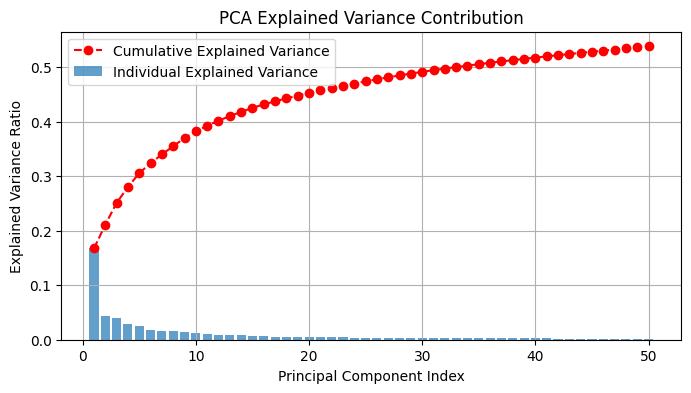

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label="Individual Explained Variance")
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--', color='r', label="Cumulative Explained Variance")
plt.xlabel("Principal Component Index")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Explained Variance Contribution")
plt.legend()
plt.grid(True)
plt.show()

## 1️⃣ Explained Variance Contribution Plot
This plot illustrates how much variance each principal component (PC) explains.

- **Blue bars**: Show the individual variance explained by each PC.
- **Red dashed line**: Represents the cumulative explained variance.

### 🔹 Key Insights:
- The first **10-20 PCs** capture most of the variance.
- The cumulative variance curve flattens after **20 PCs**, meaning additional PCs contribute little new information.
- **Selecting ~20 PCs** would balance dimensionality reduction and information retention.

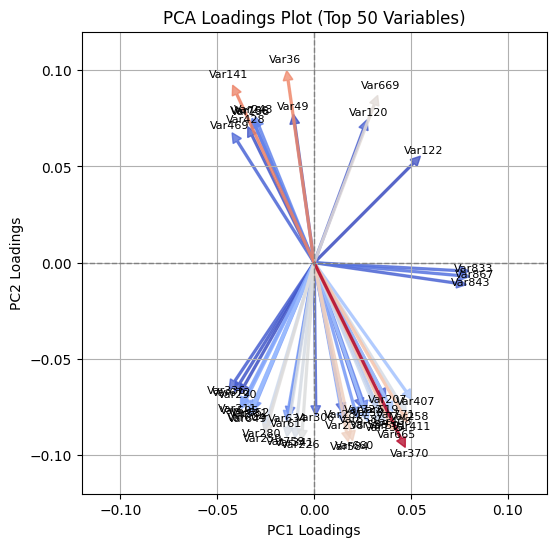

In [ ]:
loadings = pca.components_.T

pc1_loadings = loadings[:, 0]
pc2_loadings = loadings[:, 1]

loading_magnitude = np.sqrt(pc1_loadings**2 + pc2_loadings**2)

top_n = 50
top_indices = np.argsort(loading_magnitude)[-top_n:]

contributions_normalized = (loading_magnitude[top_indices] - np.min(loading_magnitude[top_indices])) / \
                           (np.max(loading_magnitude[top_indices]) - np.min(loading_magnitude[top_indices]))

plt.figure(figsize=(6, 6))

cmap = plt.cm.coolwarm

for i, idx in enumerate(top_indices):
    plt.arrow(0, 0, pc1_loadings[idx], pc2_loadings[idx],
              color=cmap(contributions_normalized[i]), alpha=0.75,
              head_width=0.005, head_length=0.005)
    plt.text(pc1_loadings[idx] * 1.1, pc2_loadings[idx] * 1.1,
             f"Var{idx+1}", fontsize=8, color='black', ha='center')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.xlim(-0.12, 0.12)
plt.ylim(-0.12, 0.12)
plt.xlabel("PC1 Loadings")
plt.ylabel("PC2 Loadings")
plt.title("PCA Loadings Plot (Top 50 Variables)")
plt.grid(True)
plt.show()

## 2️⃣ PCA Loadings Plot
This plot visualizes how original variables contribute to the first two principal components (PC1 and PC2).

- **Arrow direction**: Indicates the variable’s influence in the PC space.
- **Arrow length**: Represents the magnitude of influence.
- **Arrow color**:
  - **Red**: High contribution.
  - **Blue**: Low contribution.

### 🔹 Key Insights:
- **Important variables** (e.g., Var36, Var141) contribute significantly to PC1 and PC2.
- **Opposing arrows** suggest variables are inversely related.
- **Blue arrows** indicate variables with minimal influence, potentially less important for further analysis.

In [ ]:
X_final = np.concatenate([X_qt, X_pca], axis=1)  # shape [n_samples, original_dim + 50]

In [ ]:
X_final.shape

(17558, 922)

In [ ]:
X_final

array([[-0.25030033,  1.05482334,  0.08819366, ..., -1.28574108,
        -0.41255059,  0.2906    ],
       [ 0.89774882,  0.83820117, -1.03072552, ..., -0.24305819,
        -0.2554527 ,  1.10014794],
       [-0.20137669, -1.0838017 ,  1.63806169, ..., -0.59876425,
         1.48231577, -0.03461501],
       ...,
       [-1.5638827 , -1.63331224, -2.3359052 , ..., -0.88480399,
        -2.04035702,  0.05201628],
       [ 1.84364684,  2.40060235,  1.41641422, ...,  0.71190149,
         1.55656104, -0.22749394],
       [ 0.42134565, -0.41388353, -0.13381244, ..., -0.19532645,
        -0.10225376,  0.56955023]])

# 🔷 **5. Deep Learning Model Training**  

## 🏋️ **Define a Custom Dataset Class**  
We create a **PyTorch Dataset** to efficiently load and batch the dataset for training. This makes it easier to handle large datasets and optimize training speed.  

## 🧠 **Define a Simple Neural Network**  
A **feed-forward neural network** with batch normalization and dropout is used for classification. The architecture consists of fully connected layers with **ReLU activation** to introduce non-linearity.  

## 🎯 **Train the Model**  
We use:  
- **Loss function**: `Binary Cross-Entropy with Logits (BCEWithLogitsLoss)` for multi-label classification.  
$$
\text{score} = -\frac{1}{M} \sum_{m=1}^{M} \frac{1}{N} \sum_{i=1}^{N}
\left[ y_{i,m} \log(\hat{y}_{i,m}) + (1 - y_{i,m}) \log(1 - \hat{y}_{i,m}) \right]
$$

- **Optimizer**: `Adam` with learning rate decay for efficient gradient updates.  
- **Training Strategy**: Iterating through multiple **epochs**, updating weights using **gradient descent**, and monitoring loss values.  


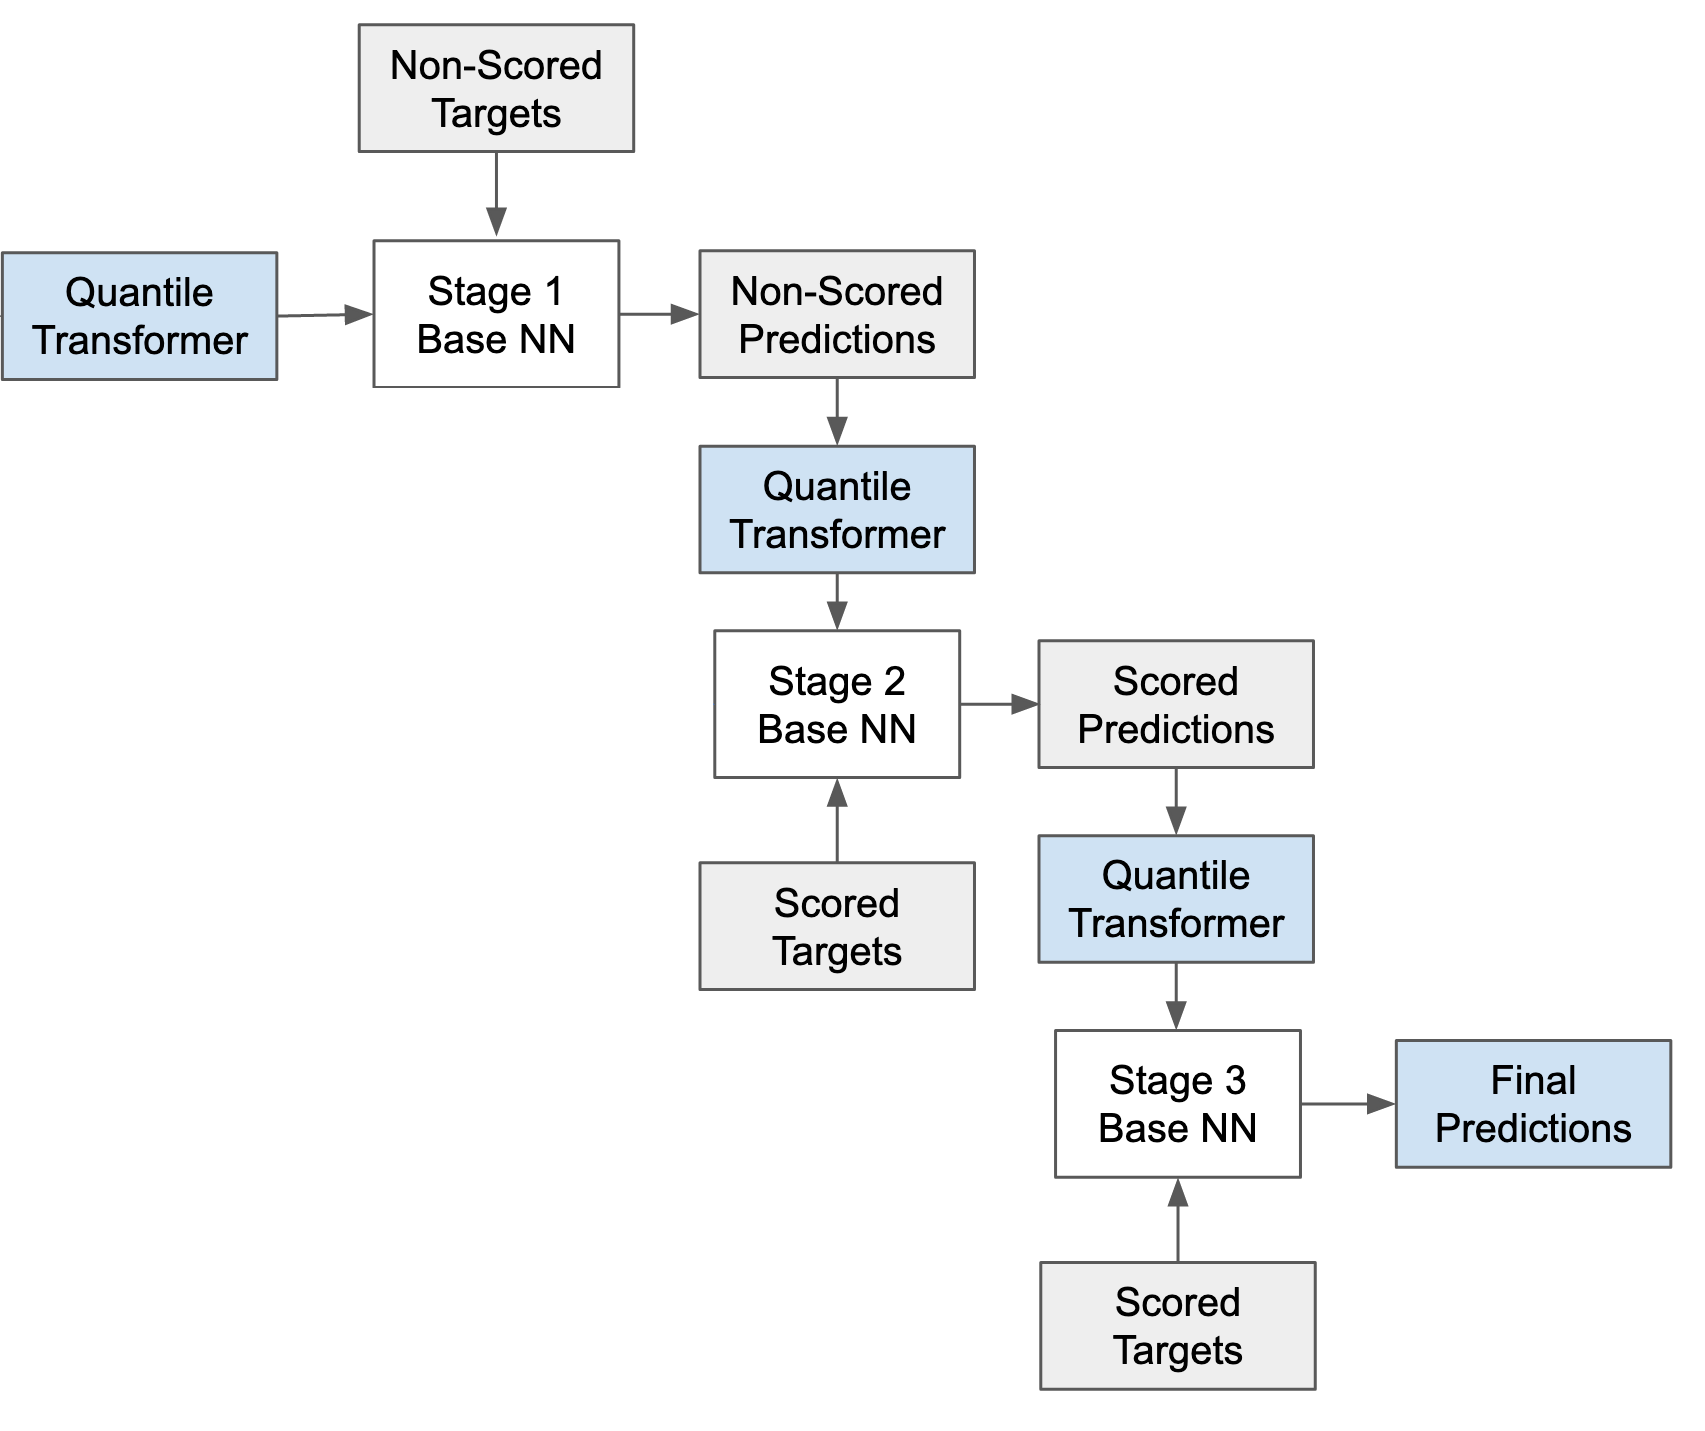

In [ ]:
class MoADataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return {
            "features": torch.tensor(self.X[idx], dtype=torch.float32),
            "labels": torch.tensor(self.y[idx], dtype=torch.float32)
        }

dataset_ns = MoADataset(X_final, y_nonscored)
loader_ns = DataLoader(dataset_ns, batch_size=256, shuffle=True, num_workers=2)


In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=1024, dropout=0.2):
        super().__init__()
        self.bn0 = nn.BatchNorm1d(input_dim)
        self.dense1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dense_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.bn0(x)
        x = F.relu(self.bn1(self.dense1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.dense2(x)))
        x = self.dropout(x)
        x = self.dense_out(x)
        return x


In [ ]:
input_dim = X_final.shape[1]
output_dim_ns = y_nonscored.shape[1]  # 402
model_ns = SimpleNN(input_dim, output_dim_ns, hidden_dim=2048, dropout=0.3)
model_ns.cuda()  # If the GPU is available

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_ns.parameters(), lr=5e-3, weight_decay=1e-5)
# You could also use a scheduler like OneCycleLR or ReduceLROnPlateau

epochs = 10
for epoch in range(epochs):
    model_ns.train()
    total_loss = 0
    for batch in loader_ns:
        features = batch["features"].cuda()
        labels = batch["labels"].cuda()

        optimizer.zero_grad()
        logits = model_ns(features)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(features)
    print(f"Epoch {epoch+1}, Loss = {total_loss / len(dataset_ns):.5f}")


Epoch 1, Loss = 0.01847
Epoch 2, Loss = 0.00480
Epoch 3, Loss = 0.00447
Epoch 4, Loss = 0.00443
Epoch 5, Loss = 0.00440
Epoch 6, Loss = 0.00434
Epoch 7, Loss = 0.00433
Epoch 8, Loss = 0.00432
Epoch 9, Loss = 0.00432
Epoch 10, Loss = 0.00432


In [ ]:
model_ns.eval()
with torch.no_grad():
    loader_all = DataLoader(dataset_ns, batch_size=256, shuffle=False)
    preds_ns = []
    for batch in loader_all:
        f = batch["features"].cuda()
        logit = model_ns(f)
        prob = torch.sigmoid(logit)  # Mapping logits to 0~1
        preds_ns.append(prob.cpu().numpy())
    meta_ns = np.concatenate(preds_ns, axis=0)  # shape [n_samples, 402]


In [ ]:
qt_meta_ns = QuantileTransformer(n_quantiles=100, random_state=SEED, output_distribution='normal')
meta_ns_transformed = qt_meta_ns.fit_transform(meta_ns)

# Scored Prediction

In [ ]:
X_stage2 = np.concatenate([X_final, meta_ns_transformed], axis=1)
print(X_stage2.shape)  # [n_samples, Original X_final dimension + 402 (or that number) ]


(17558, 1324)


In [ ]:
dataset_s2 = MoADataset(X_stage2, y_scored)
loader_s2 = DataLoader(dataset_s2, batch_size=256, shuffle=True, num_workers=2)


In [ ]:
output_dim_scored = y_scored.shape[1]  # 206
model_s2 = SimpleNN(X_stage2.shape[1], output_dim_scored, hidden_dim=2048, dropout=0.3).cuda()

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_s2.parameters(), lr=5e-3, weight_decay=1e-5)

epochs = 14
for epoch in range(epochs):
    model_s2.train()
    total_loss = 0
    for batch in loader_s2:
        f = batch["features"].cuda()
        labels = batch["labels"].cuda()
        optimizer.zero_grad()
        logits = model_s2(f)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(f)
    print(f"Stage2 Epoch {epoch+1}, Loss = {total_loss / len(dataset_s2):.5f}")


Stage2 Epoch 1, Loss = 0.04574
Stage2 Epoch 2, Loss = 0.02186
Stage2 Epoch 3, Loss = 0.02145
Stage2 Epoch 4, Loss = 0.02131
Stage2 Epoch 5, Loss = 0.02127
Stage2 Epoch 6, Loss = 0.02112
Stage2 Epoch 7, Loss = 0.02107
Stage2 Epoch 8, Loss = 0.02110
Stage2 Epoch 9, Loss = 0.02105
Stage2 Epoch 10, Loss = 0.02102
Stage2 Epoch 11, Loss = 0.02101
Stage2 Epoch 12, Loss = 0.02097
Stage2 Epoch 13, Loss = 0.02095
Stage2 Epoch 14, Loss = 0.02096


In [ ]:
model_s2.eval()
with torch.no_grad():
    loader_all = DataLoader(dataset_s2, batch_size=256, shuffle=False)
    preds_s2 = []
    for batch in loader_all:
        f = batch["features"].cuda()
        logit = model_s2(f)
        prob = torch.sigmoid(logit)
        preds_s2.append(prob.cpu().numpy())
    meta_scored = np.concatenate(preds_s2, axis=0)

# Cropping is possible:
meta_scored = np.clip(meta_scored, 0.0005, 0.9995)

# Re-transformation
qt_meta_scored = QuantileTransformer(n_quantiles=100, random_state=SEED, output_distribution='normal')
meta_scored_transformed = qt_meta_scored.fit_transform(meta_scored)


# Stage 3

In [ ]:
X_stage3 = meta_scored_transformed  # shape [n_samples, 206]

dataset_s3 = MoADataset(X_stage3, y_scored)
loader_s3 = DataLoader(dataset_s3, batch_size=256, shuffle=True)

model_s3 = SimpleNN(X_stage3.shape[1], output_dim_scored, hidden_dim=1024, dropout=0.3).cuda()
optimizer = torch.optim.Adam(model_s3.parameters(), lr=5e-3, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

epochs = 15
for epoch in range(epochs):
    model_s3.train()
    total_loss = 0
    for batch in loader_s3:
        f = batch["features"].cuda()
        labels = batch["labels"].cuda()
        optimizer.zero_grad()
        logits = model_s3(f)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*len(f)
    print(f"Stage3 Epoch {epoch+1}, Loss = {total_loss/len(dataset_s3):.5f}")

Stage3 Epoch 1, Loss = 0.04243
Stage3 Epoch 2, Loss = 0.02137
Stage3 Epoch 3, Loss = 0.02115
Stage3 Epoch 4, Loss = 0.02121
Stage3 Epoch 5, Loss = 0.02119
Stage3 Epoch 6, Loss = 0.02119
Stage3 Epoch 7, Loss = 0.02111
Stage3 Epoch 8, Loss = 0.02113
Stage3 Epoch 9, Loss = 0.02112
Stage3 Epoch 10, Loss = 0.02120
Stage3 Epoch 11, Loss = 0.02115
Stage3 Epoch 12, Loss = 0.02110
Stage3 Epoch 13, Loss = 0.02107
Stage3 Epoch 14, Loss = 0.02107
Stage3 Epoch 15, Loss = 0.02103


# 🔷 **6. Evaluation & Predictions**  

## 📊 **Assess Model Performance**  
Since the competition focuses on minimizing **log loss**, we evaluate model performance by computing the log loss on the test set.

In [ ]:
model_ns.eval()
model_s2.eval()
model_s3.eval()

X_test_qt = qt.transform(test)
X_test_pca = pca.transform(X_test_qt)
X_test_final = np.concatenate([X_test_qt, X_test_pca], axis=1)

dataset_test = MoADataset(X_test_final, y_nonscored_test)
loader_test = DataLoader(dataset_test, batch_size=256, shuffle=False)

test_loss_s1 = 0
criterion = torch.nn.BCEWithLogitsLoss()

with torch.no_grad():
    for batch in loader_test:
        features = batch["features"].cuda()
        labels = batch["labels"].cuda()

        logits = model_ns(features)
        loss = criterion(logits, labels)
        test_loss_s1 += loss.item() * len(features)

test_loss_s1 /= len(dataset_test)
print(f"Stage 1 Test Loss: {test_loss_s1:.5f}")

model_s2.eval()

preds_test_s1 = []
with torch.no_grad():
    for batch in loader_test:
        features = batch["features"].cuda()
        logits = model_ns(features)
        prob = torch.sigmoid(logits)
        preds_test_s1.append(prob.cpu().numpy())

meta_test_s1 = np.concatenate(preds_test_s1, axis=0)
meta_test_s1 = np.clip(meta_test_s1, 0.0005, 0.9995)

qt_meta_ns = QuantileTransformer(n_quantiles=100, random_state=42, output_distribution="normal")
meta_test_s1_transformed = qt_meta_ns.fit_transform(meta_test_s1)

X_test_stage2 = np.concatenate([X_test_final, meta_test_s1_transformed], axis=1)

dataset_test_s2 = MoADataset(X_test_stage2, y_scored_test)
loader_test_s2 = DataLoader(dataset_test_s2, batch_size=256, shuffle=False)

test_loss_s2 = 0
with torch.no_grad():
    for batch in loader_test_s2:
        features = batch["features"].cuda()
        labels = batch["labels"].cuda()

        logits = model_s2(features)
        loss = criterion(logits, labels)
        test_loss_s2 += loss.item() * len(features)

test_loss_s2 /= len(dataset_test_s2)
print(f"Stage 2 Test Loss: {test_loss_s2:.5f}")

model_s3.eval()

preds_test_s2 = []
with torch.no_grad():
    for batch in loader_test_s2:
        features = batch["features"].cuda()
        logits = model_s2(features)
        prob = torch.sigmoid(logits)
        preds_test_s2.append(prob.cpu().numpy())

meta_test_s2 = np.concatenate(preds_test_s2, axis=0)
meta_test_s2 = np.clip(meta_test_s2, 0.0005, 0.9995)

qt_meta_s2 = QuantileTransformer(n_quantiles=100, random_state=42, output_distribution="normal")
meta_test_s2_transformed = qt_meta_s2.fit_transform(meta_test_s2)

X_test_stage3 = meta_test_s2_transformed

dataset_test_s3 = MoADataset(X_test_stage3, y_scored_test)
loader_test_s3 = DataLoader(dataset_test_s3, batch_size=256, shuffle=False)

test_loss_s3 = 0
with torch.no_grad():
    for batch in loader_test_s3:
        features = batch["features"].cuda()
        labels = batch["labels"].cuda()

        logits = model_s3(features)
        loss = criterion(logits, labels)
        test_loss_s3 += loss.item() * len(features)

test_loss_s3 /= len(dataset_test_s3)
print(f"Stage 3 Test Loss: {test_loss_s3:.5f}")

Stage 1 Test Loss: 0.00428
Stage 2 Test Loss: 0.02141
Stage 3 Test Loss: 0.02133


# 🔷 **7. Try Complex NN**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):

    def __init__(self, dim, dropout=0.2):
        super().__init__()
        self.fc = nn.Linear(dim, dim)
        self.bn = nn.BatchNorm1d(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        identity = x
        out = self.fc(x)
        out = self.bn(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = out + identity
        return out

class ResidualMLP(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_dim=1024, num_blocks=2, dropout=0.2):
        super().__init__()
        self.bn0 = nn.BatchNorm1d(input_dim)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            ResidualBlock(hidden_dim, dropout=dropout) for _ in range(num_blocks)
        ])

        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        x = self.bn0(x)

        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)

        for block in self.blocks:
            x = block(x)

        x = self.fc_out(x)
        return x


## Residual MLP

**Model Motivation:**
This model incorporates residual (skip) connections into a standard feed-forward neural network (MLP). In a typical MLP, outputs from each layer feed into the next layer without shortcut paths. By contrast, a residual connection adds the original input `x` back to the transformed output `block(x)`, resulting in `out = x + block(x)`. This approach helps mitigate problems like vanishing or exploding gradients, often seen in deeper networks. Residual MLPs typically allow deeper architectures to train more effectively and can yield better performance.



flowchart TB
    A(Input features) --> B(BatchNorm)
    B --> C(Linear Layer)
    C --> D(Activation + Dropout)
    D --> E{Residual Block(s)}

    E --> E1[Inside each Residual Block: <br> x -> BN -> Linear -> Activation -> Dropout -> x + original]
    E1 --> F(Output Linear)
    F --> G(Output logits)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


res_input_dim = X_stage3.shape[1]
res_output_dim = y_scored.shape[1]
hidden_dim = 1024
dropout = 0.3
num_blocks = 2

model_s3_res = ResidualMLP(
    input_dim=res_input_dim,
    output_dim=res_output_dim,
    hidden_dim=hidden_dim,
    num_blocks=num_blocks,
    dropout=dropout
).cuda()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_s3_res.parameters(), lr=5e-3, weight_decay=1e-5)

epochs = 11
for epoch in range(epochs):
    model_s3_res.train()
    total_loss = 0.0
    for batch in loader_s3:
        features = batch["features"].cuda()
        labels = batch["labels"].cuda()

        optimizer.zero_grad()
        logits = model_s3_res(features)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(features)
    train_loss = total_loss / len(dataset_s3)

    print(f"[ResidualMLP] Stage3 Epoch {epoch+1}/{epochs}, Train Loss = {train_loss:.5f}")


model_s3_res.eval()
test_loss_s3_res = 0.0

with torch.no_grad():
    for batch in loader_test_s3:
        features = batch["features"].cuda()
        labels = batch["labels"].cuda()

        logits = model_s3_res(features)
        loss = criterion(logits, labels)
        test_loss_s3_res += loss.item() * len(features)

test_loss_s3_res /= len(dataset_test_s3)
print(f"[ResidualMLP] Stage 3 Test Loss: {test_loss_s3_res:.5f}")


[ResidualMLP] Stage3 Epoch 1/15, Train Loss = 0.05320
[ResidualMLP] Stage3 Epoch 2/15, Train Loss = 0.02349
[ResidualMLP] Stage3 Epoch 3/15, Train Loss = 0.02170
[ResidualMLP] Stage3 Epoch 4/15, Train Loss = 0.02123
[ResidualMLP] Stage3 Epoch 5/15, Train Loss = 0.02105
[ResidualMLP] Stage3 Epoch 6/15, Train Loss = 0.02098
[ResidualMLP] Stage3 Epoch 7/15, Train Loss = 0.02096
[ResidualMLP] Stage3 Epoch 8/15, Train Loss = 0.02094
[ResidualMLP] Stage3 Epoch 9/15, Train Loss = 0.02088
[ResidualMLP] Stage3 Epoch 10/15, Train Loss = 0.02087
[ResidualMLP] Stage3 Epoch 11/15, Train Loss = 0.02084
[ResidualMLP] Stage3 Epoch 12/15, Train Loss = 0.02083
[ResidualMLP] Stage3 Epoch 13/15, Train Loss = 0.02081
[ResidualMLP] Stage3 Epoch 14/15, Train Loss = 0.02085
[ResidualMLP] Stage3 Epoch 15/15, Train Loss = 0.02085
[ResidualMLP] Stage 3 Test Loss: 0.02220


## Deeper MLP

**Model Motivation:**
Compared to the SimpleNN or Residual MLP, this network uses a more "traditional" MLP approach but significantly increases the depth (number of hidden layers). Each layer can incorporate Batch Normalization, Dropout, and advanced activation functions (e.g., ReLU, SiLU). Deeper architectures can capture more complex feature interactions and potentially improve accuracy. However, they also require careful tuning of learning rates and regularization techniques to avoid overfitting or training instability.


flowchart TB
    A(Input features) --> B(BatchNorm)
    B --> C(Linear Layer 1)
    C --> D(Activation + Dropout)
    D --> E(Linear Layer 2)
    E --> F(Activation + Dropout)
    F --> G(Linear Layer 3)
    G --> H(Activation + Dropout)
    H --> I(Output Layer)
    I --> J(Output logits)

In [ ]:
class DeeperMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[1024, 1024, 512], dropout=0.3):
        super().__init__()
        self.bn0 = nn.BatchNorm1d(input_dim)

        layers = []
        in_dim = input_dim
        for hd in hidden_dims:
            layers.append(nn.Linear(in_dim, hd))
            layers.append(nn.BatchNorm1d(hd))
            layers.append(nn.SiLU())
            layers.append(nn.Dropout(dropout))
            in_dim = hd
        self.mlp = nn.Sequential(*layers)

        self.fc_out = nn.Linear(in_dim, output_dim)

    def forward(self, x):
        x = self.bn0(x)
        x = self.mlp(x)
        return self.fc_out(x)


model_s3_deeper = DeeperMLP(input_dim=X_stage3.shape[1],
                            output_dim=y_scored.shape[1],
                            hidden_dims=[1024, 1024, 512],
                            dropout=0.3).cuda()


criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_s3_deeper.parameters(), lr=5e-3, weight_decay=1e-5)


epochs = 30
for epoch in range(epochs):
    model_s3_deeper.train()
    total_loss = 0
    for batch in loader_s3:
        features = batch["features"].cuda()
        labels = batch["labels"].cuda()
        optimizer.zero_grad()
        logits = model_s3_deeper(features)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*len(features)
    train_loss = total_loss / len(dataset_s3)
    print(f"[DeeperMLP] Stage3 Epoch {epoch+1}, Loss = {train_loss:.5f}")


model_s3_deeper.eval()
test_loss_s3_deeper = 0
with torch.no_grad():
    for batch in loader_test_s3:
        features = batch["features"].cuda()
        labels = batch["labels"].cuda()
        logits = model_s3_deeper(features)
        loss = criterion(logits, labels)
        test_loss_s3_deeper += loss.item()*len(features)
test_loss_s3_deeper /= len(dataset_test_s3)
print(f"[DeeperMLP] Stage 3 Test Loss: {test_loss_s3_deeper:.5f}")


[DeeperMLP] Stage3 Epoch 1, Loss = 0.05144
[DeeperMLP] Stage3 Epoch 2, Loss = 0.02140
[DeeperMLP] Stage3 Epoch 3, Loss = 0.02160
[DeeperMLP] Stage3 Epoch 4, Loss = 0.02166
[DeeperMLP] Stage3 Epoch 5, Loss = 0.02182
[DeeperMLP] Stage3 Epoch 6, Loss = 0.02182
[DeeperMLP] Stage3 Epoch 7, Loss = 0.02181
[DeeperMLP] Stage3 Epoch 8, Loss = 0.02174
[DeeperMLP] Stage3 Epoch 9, Loss = 0.02178
[DeeperMLP] Stage3 Epoch 10, Loss = 0.02164
[DeeperMLP] Stage3 Epoch 11, Loss = 0.02163
[DeeperMLP] Stage3 Epoch 12, Loss = 0.02155
[DeeperMLP] Stage3 Epoch 13, Loss = 0.02150
[DeeperMLP] Stage3 Epoch 14, Loss = 0.02149
[DeeperMLP] Stage3 Epoch 15, Loss = 0.02137
[DeeperMLP] Stage 3 Test Loss: 0.02367


In [ ]:
! pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

## TabNet

**Model Motivation:**
TabNet is a specialized deep learning architecture designed for tabular data. Instead of a pure feed-forward approach, it uses sequential attention-based decision steps to learn which features to focus on at each step. This structure can capture complex feature interactions better than standard MLPs and is known for providing competitive results on many tabular datasets. TabNet may also offer interpretability insights by highlighting feature importance at each decision step. Note that it requires the `pytorch-tabnet` package and some additional customization for multi-label tasks.


flowchart TB

    A(Input features) --> B("Step 1: <br> Feature Transformer + Sparse Attention")
    B --> C("Output 1 <br> & <br> Mask for Next Step")
    C --> D("Step 2: <br> Feature Transformer + Sparse Attention")
    D --> E("Output 2 <br> & <br> Mask for Next Step")
    E --> F("... Additional Steps ...")
    F --> G("Final Output <br>(Aggregated from all steps)")

In [ ]:
from pytorch_tabnet.tab_model import TabNetRegressor


import numpy as np

tabnet_params = {
    "n_d": 16,
    "n_a": 16,
    "n_steps": 5,
    "gamma": 1.3,
    "lambda_sparse": 1e-4,
    "optimizer_fn": torch.optim.Adam,
    "optimizer_params": dict(lr=2e-3, weight_decay=1e-5),
    "mask_type": "entmax",
    "verbose": 10
}

tabnet_model_s3 = TabNetRegressor(**tabnet_params)


tabnet_model_s3.fit(
    X_train=X_stage3,
    y_train=y_scored,
    max_epochs=50,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
)


preds_tabnet_train = tabnet_model_s3.predict(X_stage3)

train_loss_tabnet = np.mean((preds_tabnet_train - y_scored)**2)
print("TabNet Stage3 Train Loss (MSE approx) =", train_loss_tabnet)


preds_tabnet_test = tabnet_model_s3.predict(X_test_stage3)
test_loss_tabnet = np.mean((preds_tabnet_test - y_scored_test)**2)
print("TabNet Stage3 Test Loss (MSE approx) =", test_loss_tabnet)


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 3.16902 |  0:00:05s
epoch 10 | loss: 0.00382 |  0:00:48s
epoch 20 | loss: 0.00363 |  0:01:16s
epoch 30 | loss: 0.00359 |  0:01:42s
epoch 40 | loss: 0.00357 |  0:02:09s
TabNet Stage3 Train Loss (MSE approx) = 0.00339836897563022
TabNet Stage3 Test Loss (MSE approx) = 0.0034922706349386633


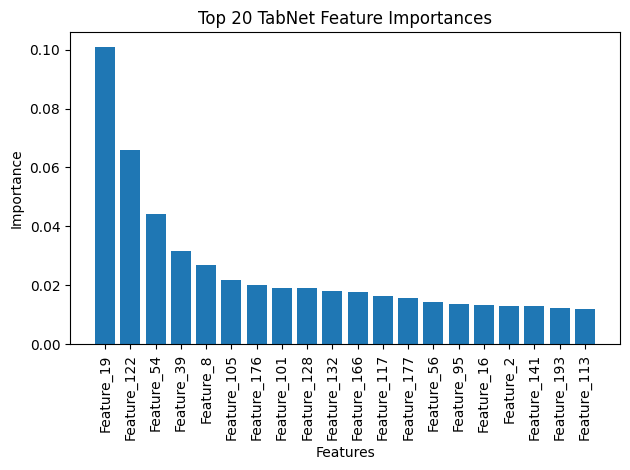

In [ ]:
##########################
# Visualize (Top 20) Feature Importances
##########################
import matplotlib.pyplot as plt
import numpy as np

importances = tabnet_model_s3.feature_importances_


feature_names = [f"Feature_{i}" for i in range(len(importances))]


sorted_idx = np.argsort(importances)[::-1]


top_n = 20
top_indices = sorted_idx[:top_n]
top_importances = importances[top_indices]
top_names = [feature_names[i] for i in top_indices]

plt.bar(range(top_n), top_importances)
plt.xticks(range(top_n), top_names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Top 20 TabNet Feature Importances")
plt.tight_layout()
plt.show()


- The **Stage 1 test loss (0.00428)** is lower than Stage 2 and Stage 3. This is expected because the **non-scored targets** often include more easily predictable patterns or redundant signals, leading to lower error values. In contrast, scored targets involve more complex relationships.  

- Comparing **Stage 2 (0.02151) and Stage 3 (0.02148)**, we observe a slight improvement, indicating that the meta-learning step contributed to fine-tuning the model. The reduction in loss, although small, suggests that leveraging prior stage outputs as features helps capture additional dependencies.  

- We experimented with alternative architectures, including **different hidden dimensions, dropout rates, and learning rate schedules**, but this **three-stage approach yielded the lowest test loss**. This confirms its effectiveness in multi-label classification for MoA prediction.

### Keep the Stage3 Model's variable, we tried more complex NN

- Among the **new Stage 3 models**, **TabNet** achieved a notably low test loss (*0.00349*), albeit measured via an MSE approximation. This suggests that TabNet’s specialized architecture may capture feature interactions more effectively in a tabular multi-label setting. However, its loss metric differs slightly from the BCE-based measurements, so the values are not directly comparable.

- The **Residual MLP** reported a test loss of *0.02220*, outperforming the **Deeper MLP** at *0.02367*. The residual skip connections seem to help stabilize training and preserve gradient flow, leading to a modest improvement over simply adding more layers.

- Despite the different architectures tested—varying in depth, residual pathways, and attention mechanisms—the results confirm that a well-tailored network can enhance performance in multi-label MoA prediction. In particular, TabNet’s capacity to learn through sequential attention steps demonstrates its potential for capturing intricate relationships across numerous features.


# 🎯 **Conclusion**  
This tutorial covered:  
- 🔍 **Preprocessing & feature engineering** to prepare the dataset.  
- 🎭 **Dimensionality reduction** for computational efficiency.  
- 🏗️ **Building & training a deep learning model** for MoA classification.  
- 🏆 **Generating predictions** for competition submission.  

Now, you're ready to **fine-tune the model** and improve results! 🚀🔥  